In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gc

# --- System Parameters ---
mass = 1.0
hbar = (1/5)**0.5 # 1.0

# --- Potential Parameters (Square Well) ---
V0_well_depth = 1.0  # Depth of the square well (a positive value)           
L_potential = 20.0    # Width of the square well

# --- Spatial Grid Parameters ---
L_simulation = 40.0 
N_grid = 5000      # Adjust this to test convergence
dx = L_simulation / N_grid
x = np.linspace(-L_simulation, L_simulation, N_grid)



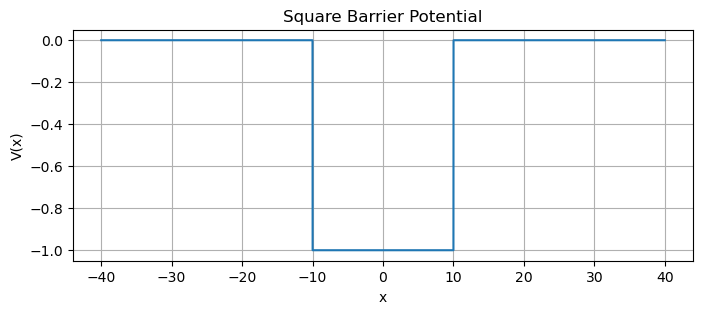

In [ ]:
def square_well_potential(x_coords, V0_depth, L_width):
    """
    Defines a square well potential of depth V0.
    """
    potential = np.zeros(x_coords.shape)
    potential[np.abs(x_coords) <= L_width / 2] = -V0_depth
    return potential

# Calculate the potential array for the current grid
potential_array = square_well_potential(x, V0_well_depth, L_potential)

# Optional: Plot the potential to verify
plt.figure(figsize=(8,3))
plt.plot(x, potential_array)
plt.title("Square Barrier Potential")
plt.xlabel("x")
plt.ylabel("V(x)")
plt.grid(True)
plt.show()


In [41]:
def numerical_transmission(E_val, V0_depth, L_width, mass, hbar, L_sim, N):
    if E_val <= 0: return 0.0

    k = np.sqrt(2 * mass * E_val) / hbar
    x_coords = np.linspace(-L_sim, L_sim, N)
    dx = x_coords[1] - x_coords[0]
    
    potential_at_points = square_well_potential(x_coords, V0_depth, L_width)

    K = np.zeros((N, N), dtype=np.complex128)
    gamma = -1j * mass * dx / (hbar**2 * k)

    # This optimization is effective for a square potential
    # as the potential is exactly zero outside the well.
    potential_indices = np.where(potential_at_points != 0)[0]
    for i in range(N):
        for j in potential_indices:
            G_val = np.exp(1j * k * np.abs(x_coords[i] - x_coords[j]))
            K[i, j] = gamma * potential_at_points[j] * G_val
    
    A = np.eye(N, dtype=np.complex128) - K
    phi = np.exp(1j * k * x_coords)
    
    try:
        psi = np.linalg.solve(A, phi)
    except np.linalg.LinAlgError:
        print(f"  WARNING: Singular matrix at E={E_val:.3f}. Returning T=NaN.")
        return np.nan
    
    # plt.plot(x_coords,psi)
    # plt.show()

    trans_mask = x_coords > (L_sim / 2)
    x_right = x_coords[trans_mask]
    
    if len(x_right) < 2:
        return np.nan

    M_trans = np.vstack([np.exp(1j * k * x_right), np.exp(-1j * k * x_right)]).T
    coeffs_trans, _, _, _ = np.linalg.lstsq(M_trans, psi[trans_mask], rcond=None)
    
    t_num = coeffs_trans[0]

    del A, K, psi
    gc.collect()
    
    return np.abs(t_num)**2                    

In [42]:
def analytical_transmission_square_well(E_val, V0_depth, L_width, mass, hbar):
    if E_val <= 0: return 0.0
    
    # Wavenumber inside the well
    q = np.sqrt(2 * mass * (E_val + V0_depth)) / hbar
    
    # Argument of the sine function
    qL = q * L_width
    
    # The formula is T = [1 + (V0^2 * sin^2(qL)) / (4E(E+V0))]^(-1)
    denominator_term = 4 * E_val * (E_val + V0_depth)
    
    if np.abs(denominator_term) < 1e-12:
        return np.nan # Avoid division by zero
    
    term_in_bracket = 1 + (V0_depth**2 * np.sin(qL)**2) / denominator_term
    
    return 1.0 / term_in_bracket 

Calculating analytical values...
Calculating numerical values... 


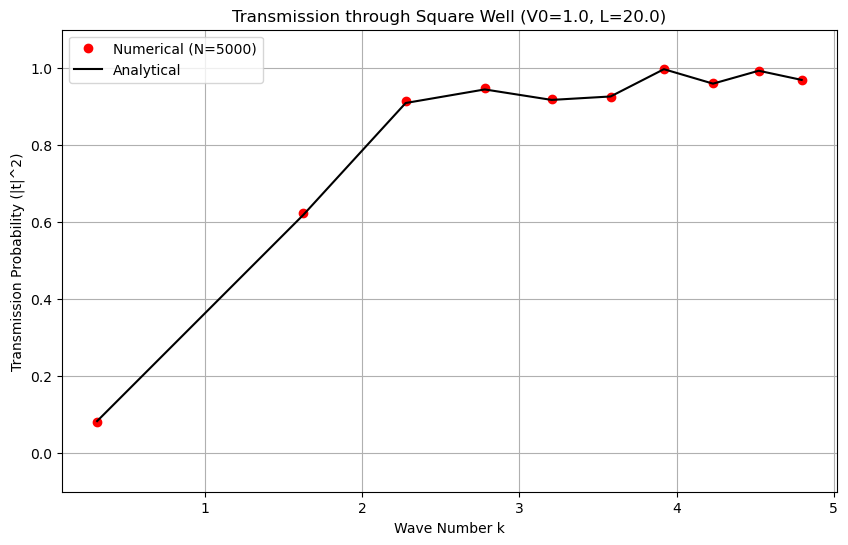

In [43]:
energy_min_plot, energy_max_plot = 0.01, 2.3
n_energy_points = 10

energy_values = np.linspace(energy_min_plot, energy_max_plot, n_energy_points)
k_values_plot = np.sqrt(2 * mass * energy_values) / hbar

print("Calculating analytical values...")
analytical_results = [
    analytical_transmission_square_well(E, V0_well_depth, L_potential, mass, hbar) 
    for E in energy_values
]

energy_values = np.linspace(energy_min_plot, energy_max_plot, n_energy_points)

print("Calculating numerical values... ")
numerical_results = [
    numerical_transmission(E, V0_well_depth, L_potential, mass, hbar, L_simulation, N_grid) 
    for E in energy_values
]

plt.figure(figsize=(10, 6))
plt.plot(k_values_plot, numerical_results, 'ro', label=f'Numerical (N={N_grid})')
plt.plot(k_values_plot, analytical_results, 'k-', label='Analytical')
plt.xlabel('Wave Number k')
plt.ylabel('Transmission Probability (|t|^2)')
plt.title(f'Transmission through Square Well (V0={V0_well_depth}, L={L_potential})')
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.show()

In [33]:
# k_values_plot = np.sqrt(2 * mass * energy_values) / hbar
# plt.figure(figsize=(10, 6))
# plt.plot(k_values_plot, numerical_results, 'ro', label=f'Numerical (N={N_grid})')

# energy_values = np.linspace(energy_min_plot, energy_max_plot, 1000)
# k_values_plot = np.sqrt(2 * mass * energy_values) / hbar

# plt.plot(k_values_plot, analytical_results, 'k-', label='Analytical')
# plt.xlabel('Wave Number k')
# plt.ylabel('Transmission Probability (|t|^2)')
# plt.title(f'Transmission through Square Well (V0={V0_well_depth}, L={L_potential})')
# plt.legend()
# plt.grid(True)
# plt.ylim(-0.1, 1.1)
# plt.show()

### Finite Element Method 